# Part 1: Predicting Housing Prices with a Simple Linear Model

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import deepcopy

%matplotlib inline

**Download the dataset.**  
This dataset comes from the University of Washington Coursera Class 'ML-Foundations'  
_Source:_ https://www.coursera.org/learn/ml-foundations

In [131]:
! curl https://d396qusza40orc.cloudfront.net/phoenixassets/home_data.csv -o ./home_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2537k  100 2537k    0     0   133k      0  0:00:19  0:00:19 --:--:--  239k  0  82238      0  0:00:31  0:00:08  0:00:23 98773


Read in the data

In [132]:
df = pd.read_csv('home_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [133]:
df[['price','sqft_living','zipcode']].head(12)

,price,sqft_living,zipcode
0,221900,1180,98178
1,538000,2570,98125
2,180000,770,98028
3,604000,1960,98136
4,510000,1680,98074
5,1225000,5420,98053
6,257500,1715,98003
7,291850,1060,98198
8,229500,1780,98146
9,323000,1890,98038


## A basic linear regression model

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Let's create a simple linear regression model to predict housing price based on square footage

In [135]:
df['price_log'] = df['price'].apply(lambda x: np.log(x))
df['sqft_log'] = df['sqft_living'].apply(lambda x: np.log(x))

In [136]:
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(df[['sqft_log']], df[['price_log']],
                                                    test_size=0.33, random_state=42)

lr.fit(X_train, y_train)
print('Intercept:', lr.intercept_[0])
print('Slope:', lr.coef_[0][0])
print('R2:',lr.score(X_test,y_test))
df['pred'] = lr.predict(df[['sqft_log']])

Intercept: 6.78846662885
Slope: 0.829001511752
R2: 0.463386928112


Let's plot this:

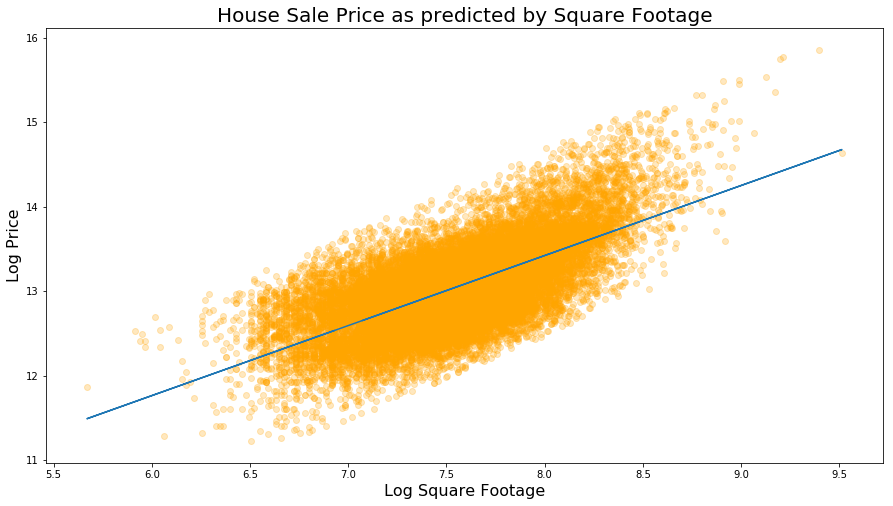

In [137]:
plt.figure(figsize=[15,8])
plt.title('House Sale Price as predicted by Square Footage', fontsize=20)
plt.ylabel('Log Price', fontsize=16)
plt.xlabel('Log Square Footage', fontsize=16)
plt.plot(df['sqft_log'],df['pred'])
plt.scatter(df['sqft_log'],df['price_log'],c='orange',alpha=0.25);

Obviously this is a pretty simple model and it doesn't capture much of the variance in the data, but for the sake of demonstration let's pretend we were limited in what/how many features we were able to use. If we had to choose one other what should it be?  
  
**Remember the three most important things in real estate:**  
  * Location  
  * Location
  * Location  
  
From the graph above we can see that there is a relationship between size of the house and sale price, but the location is also going to be a big driver for the sale price. Let's fold that in as a feature.
  
Because this is a categorical feature it would make sense to use pandas to make dummy-variables for all of the zipcodes.

In [138]:
df_zip = pd.get_dummies(df[['price','zipcode','sqft_living']], columns=['zipcode'], drop_first=True)

X_cols = df_zip.columns[1:]

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(df_zip[X_cols], df_zip[['price']],
                                                    test_size=0.33, random_state=42)

lr.fit(X_train, y_train)
print('R2:',lr.score(X_test,y_test))
df_zip['pred'] = lr.predict(df_zip[X_cols])

R2: 0.719044267589


Already a much more explanatory model.  
  
But what is really happening here? By one-hot encoding the zipcode we've essentially created a varying intercept model.  The slope for size of living space is the same regardless of location, but the intercept for two houses with the same square footage will have different estimated prices

# Part Two: Varying Intercept and Varying Slope Models

### Varying Intercept

To demonstrate varying intercept in practice let's plot the lines for the two zipcodes with the most records.

In [139]:
print(list(df.zipcode.value_counts().head(3).keys()))

[98103, 98038, 98115]


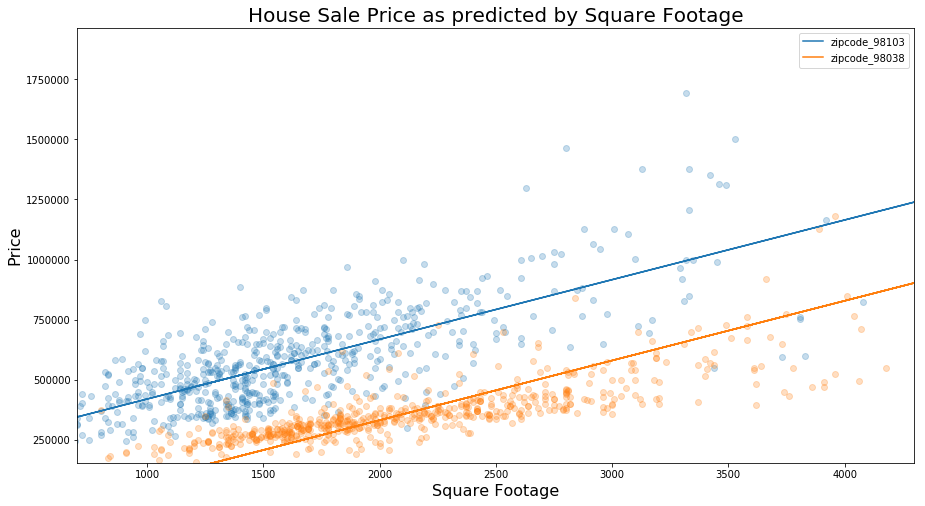

In [140]:
plt.figure(figsize=[15,8])
plt.title('House Sale Price as predicted by Square Footage', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Square Footage', fontsize=16)
plt.axis([700,4300,1.535004e+05,1.964400e+06])
plt.plot(df_zip.query('zipcode_98103 == 1')['sqft_living'],df_zip.query('zipcode_98103 == 1')['pred'])
plt.plot(df_zip.query('zipcode_98038 == 1')['sqft_living'],df_zip.query('zipcode_98038 == 1')['pred'])

plt.legend(['zipcode_98103','zipcode_98038'])

plt.scatter(df_zip.query('zipcode_98103 == 1')['sqft_living'],df_zip.query('zipcode_98103 == 1')['price'],alpha=0.25);
plt.scatter(df_zip.query('zipcode_98038 == 1')['sqft_living'],df_zip.query('zipcode_98038 == 1')['price'],alpha=0.25);

For this the use of price x sqft instead of price_log x sqft_log was to make obvios the difference in slope between the actual data and the fitl ine for zipcode 98038

In [141]:
for x,y in zip(X_cols, lr.coef_[0]):
    if x == 'zipcode_98103':
        print(x,'- intercept adjustment:', round(y,2))
        a1 = y
    if x == 'zipcode_98038':
        print(x,'- intercept adjustment:', round(y,2))
        a2 = y
print('Difference:',a1 - a2)
print('Slope:',round(lr.coef_[0][0],2))

zipcode_98038 - intercept adjustment: 26358.26
zipcode_98103 - intercept adjustment: 362927.46
Difference: 336569.199137
Slope: 248.5


Notice that the line for 98038 seems less fit than the line for 98103?  
  
This approach assumed that cost per square foot was the same for both zipcodes, but looking at how the lines fit to the data suggests otherwise. By adding in a feature interaction we can allow the slop to change for the zipcodes as well.

## Varying slope - Varying Intercept Model

To acheive a varying slope, varying intercept model let's multiply the vectors for each zipcode by the square footage.    

In [142]:
df_zip = pd.get_dummies(df[['price','zipcode','sqft_living']], columns=['zipcode'], drop_first=True)

X_cols = df_zip.columns[1:]

for x in range(1, len(X_cols)):
    df_zip['sqft_living_' + X_cols[x]] = df_zip[X_cols[x]] * df_zip['sqft_living']


X_cols = df_zip.columns[1:]

  
This allows us to train the following model: 

**Y = B0 + B1 x X1 + B2 x X2 + B3 x X1 x X2 **  
_Note: this is a simplification as B3 and X2 would be matrices not vectors_  

Where X1 = sqft_living and X2 represents the zipcode. The interaction between X1 and X2 will change the slope for each zipcode. Remember that since a record and either be in a zipcode or not this value will either be 1 x square footage or it will be 0 x square footage. 

In [143]:
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(df_zip[X_cols], df_zip[['price']], test_size=0.33, random_state=42)

lr.fit(X_train, y_train)
print('R2:',lr.score(X_test,y_test))
df_zip['pred'] = lr.predict(df_zip[X_cols])

R2: 0.780483840185


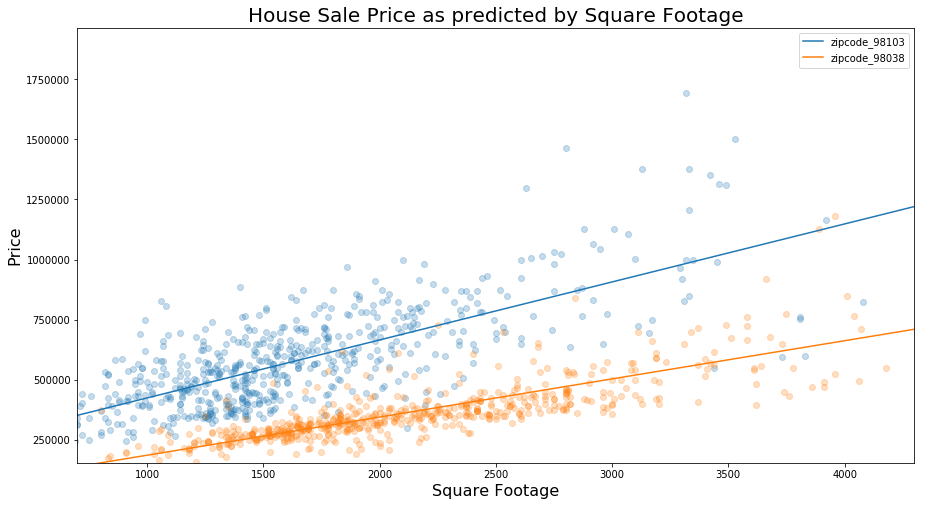

In [144]:
plt.figure(figsize=[15,8])
df_zip.sort_values('sqft_living',inplace=True)
plt.title('House Sale Price as predicted by Square Footage', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Square Footage', fontsize=16)
plt.axis([700,4300,1.535004e+05,1.964400e+06])
plt.plot(df_zip.query('zipcode_98103 == 1')['sqft_living'],df_zip.query('zipcode_98103 == 1')['pred'])
plt.plot(df_zip.query('zipcode_98038 == 1')['sqft_living'],df_zip.query('zipcode_98038 == 1')['pred'])

plt.legend(['zipcode_98103','zipcode_98038'])

plt.scatter(df_zip.query('zipcode_98103 == 1')['sqft_living'],df_zip.query('zipcode_98103 == 1')['price'],alpha=0.25);
plt.scatter(df_zip.query('zipcode_98038 == 1')['sqft_living'],df_zip.query('zipcode_98038 == 1')['price'],alpha=0.25);

Now we have lines fit to each zipcode with varying slopes and intercepts based on that zipcode. But there are limitations to this approach. Limitations that go beyond the curse of dimensionality!  
  
Imagine we get a house in a zipcode we've never seen before.  

**What will our model use as the basis for the intercept and slope?**

But if we had a full dataset with examples from every county **or** if we were only interested in the counties for which we had data there are still issues. Imagine using a boolean feature in our prediction model. Let's say we knew that waterfront view had a significant effect on the price of a house and wanted to incorporate that into our model.  
  
But much like square footage, not all waterfronts are created equal and we would want to encode an interaction for this too.  
  
In our data set there are zipcodes for which we do not have examples of waterfront properties and even for those we do some only have a few examples. 

In [145]:
df.groupby('zipcode').agg({'waterfront':'nunique'}).head(5)

,waterfront
zipcode,
98001,1
98002,1
98003,1
98004,2
98005,1


In the former case our model would once again default to the zipcode that was dropped during the creation of the dummy variables and in the latter we are highly suceptible to outliers.  

An alternative would be to maintain multiple models for groups that don't have examples of waterfront properties, but as we fold in more features of this kind this becomes less and less manageable.

### Complete and No Pooling

In moving from a single line to varying intercept - varying slope model we have also moved from **complete pooling** to **no pooling**.  
  
**Complete pooling** is where all of the data are pooled together which works sufficiently well if the variance between different groups in a categorical set (in this case zipcodes) is low.  
  
**No pooling** allows the slope and/or intercept to vary for each group in a categorical set independent of the other options. This works well when variance between options in a category is high and sufficient data are available for each option.  

Both complete and no pooling have their disadvantages:  
>**Complete pooling** undersetimates the variance between groups. (Think underfitting)    
    **No pooling** overestimates variation between groups. (Think overfitting)  



Hierarchical modeling allows for **parital pooling** where the betas for features are assumed to come from a _distribution_.

This means that (when compared to no pooling) betas are pulled towards a mean (the beta that would be associated with a no-poolin model). It requires sufficient examples to drive a beta to a point where it is independent of the mean and these special cases would look like a no pooling approach.  
  
In fact the upper and lower bounds of any beta are no-pooling and complete-pooling options.  This allows us to take advantage of information about a specific group without abandoning information about all examples all while maintaining a single model. Let's give it a go!

# Part 3: Hierarchical Linear Models with PyMC3

### PyMC3

PyMC3 models are trained in model contexts and the syntax can be a little confusing at first. Parts 1 and 2 were done in sklearn because it is more familiar for a lot of people. If the model context is confusing see Appendix A to familiarize yourself with PyMC3 syntax.

Install pymc3 with your preferred package installer

In [199]:
# ! pip install pymc3
# ! conda install pymc3

In [200]:
import pymc3 as pm
import theano
from sklearn.metrics import r2_score

Prepare the data for hierarchical modeling

Let's just look at the top 5 zipcodes for speed

In [215]:
top_zips = list(df.zipcode.value_counts().head().keys())
df_top_zips = df.query('zipcode in @top_zips').copy()

In [249]:
df_top_zips.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_code,price_log,sqft_log
9,3793500160,20150312T000000,323000,3,2.50,1890,6560,2.0,0,0,...,2003,0,98038,47.3684,-122.031,2390,7570,0,12.685408,7.544332
17,6865200140,20140529T000000,485000,4,1.00,1600,4300,1.5,0,0,...,1916,0,98103,47.6648,-122.343,1610,4300,2,13.091904,7.377759
28,5101402488,20140624T000000,438000,3,1.75,1520,6380,1.0,0,0,...,1948,0,98115,47.6950,-122.304,1520,6235,1,12.989974,7.326466
29,1873100390,20150302T000000,719000,4,2.50,2570,7173,2.0,0,0,...,2005,0,98052,47.7073,-122.110,2630,6026,3,13.485617,7.851661
32,461000390,20140624T000000,687500,4,1.75,2330,5000,1.5,0,0,...,1929,0,98117,47.6823,-122.368,1460,5000,4,13.440817,7.753624


In [216]:
zipcode_map = {}
for x,y in zip(df_top_zips.zipcode.unique(),[i for i in range(70)]):
    zipcode_map[x] = y

df_top_zips['zipcode_code'] = df_top_zips.zipcode.apply(lambda x: zipcode_map[x])

In [252]:
df_top_zips[['zipcode_code','zipcode']].head(10)

,zipcode_code,zipcode
9,0,98038
17,2,98103
28,1,98115
29,3,98052
32,4,98117
33,4,98117
35,1,98115
36,3,98052
48,1,98115
52,4,98117


Note you do not need to drop one of the zipcodes.

In [217]:
df_top_zips['price_log'] = df_top_zips.price.apply(lambda x: np.log(x))
df_top_zips['sqft_log'] = df_top_zips.sqft_living.apply(lambda x: np.log(x))

In [218]:
holdout = df_top_zips.iloc[1]
df_top_zips = df_top_zips.query('id != @holdout.id').copy()

In [219]:
zipcodes = df_top_zips.zipcode.unique()
zipcode_idx = theano.shared(df_top_zips['zipcode_code'].values)

In [220]:
model_input = theano.shared(np.array(df_top_zips.sqft_log.values))
model_output = theano.shared(np.array(df_top_zips.price_log))

y ~ N(αⱼ + βⱼχⱼ )  
>αⱼ ~ N(μₐ,σ^2)  
>βⱼ ~ N(μᵦ, σ^2)

In [228]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=10e2)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=2)
    mu_b = pm.Normal('mu_beta',mu=0., sd = 10e2)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=2)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(df_top_zips.zipcode.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(df_top_zips.zipcode.unique()))
    
    # Model error
    eps = pm.Uniform('eps', .01, 10, shape=1)
    
    # Expected value
    est = a[zipcode_idx] + b[zipcode_idx] * model_input
    
    # Data likelihood
    y = pm.Lognormal('y', mu=est, sd=eps, observed=model_output)
    
with hierarchical_model:
    # zipcode_0 - used for comparison later
    zip_0 = pm.Lognormal('zip_0', mu=a[0] + b[0], sd=eps)

In [237]:
with hierarchical_model:
    hierarchical_trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zip_0_log__, eps_interval__, beta, alpha, sigma_beta_log__, mu_beta, sigma_alpha_log__, mu_alpha]
100%|██████████| 10500/10500 [17:02<00:00, 10.27it/s]
The acceptance probability does not match the target. It is 0.935779112519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.955798359851, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.927366099373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.913104467694, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


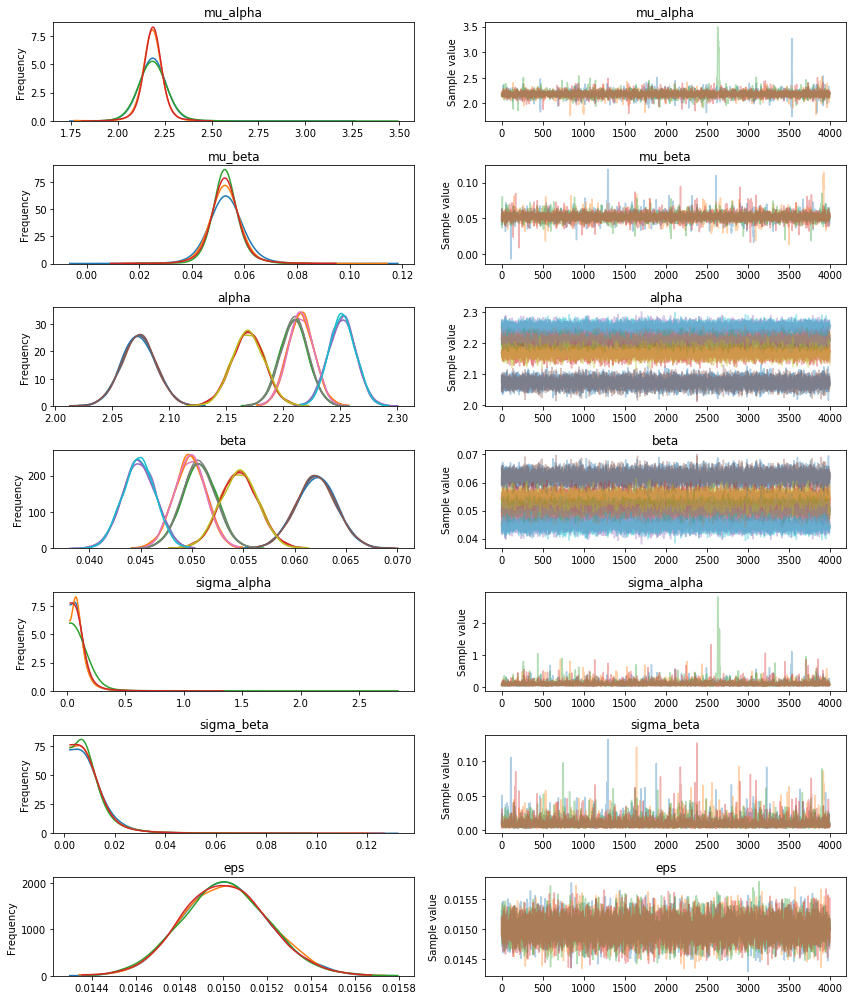

In [224]:
pm.traceplot(hierarchical_trace[1000:]);

In [225]:
# Summary 
pm.summary(hierarchical_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_alpha,2.185533,0.065756,0.001294,2.071750,2.298395,2282.398676,1.001023
mu_beta,0.052535,0.005733,0.000067,0.041813,0.063827,7088.693048,1.000119
alpha__0,2.072889,0.015040,0.000108,2.043560,2.102664,14804.647728,0.999945
alpha__1,2.215274,0.011505,0.000088,2.192516,2.237461,13811.553529,1.000013
alpha__2,2.209434,0.012203,0.000095,2.184275,2.232634,14958.135429,1.000021
alpha__3,2.168920,0.014201,0.000110,2.140934,2.196603,14411.278573,0.999909
alpha__4,2.251512,0.011756,0.000091,2.229194,2.275051,13978.541260,1.000081
beta__0,0.062078,0.001971,0.000014,0.058254,0.065991,14812.447313,0.999953
beta__1,0.049802,0.001544,0.000012,0.046838,0.052872,13835.113733,1.000005
beta__2,0.050678,0.001659,0.000013,0.047398,0.053961,14965.768513,1.000014


**Model health check**

Looking at the trace plot is one way to test the model, it shows you how the betas have converged. 
  
You can also plot the posterior distribution over the actual data. If your model is well fit it the distribution should be representative of the actual data.  
That is, the actual data should have been possible to generate from the posterior distribution.

Here we compare zipcode code 0's posterior to the mean price for that zipcode

100%|██████████| 500/500 [00:00<00:00, 2604.68it/s]


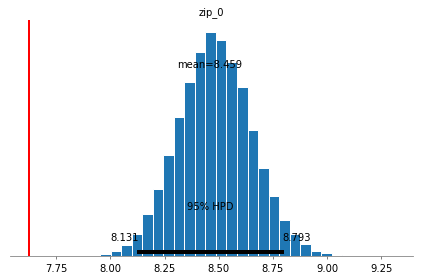

In [238]:
ppc = pm.sample_ppc(hierarchical_trace, model=hierarchical_model, samples=500)

plt.title('Posterior distribution of log_price for zipcode 98038')
pm.plot_posterior(hierarchical_trace, varnames=['zip_0'])
plt.axvline(df_top_zips.query('zipcode_code == 0').sqft_log.mean(), c='red',linewidth=2);

Let's use this hierarchical model to make a point prediction on one of our homes

In [29]:
zipcode_idx.set_value(np.asarray([holdout.zipcode_code]))
model_input.set_value(np.asarray([holdout.sqft_log]))

We can set the output for prediction to 0 since we don't actually know this information.  
It can actually be set to anything, but it does need to be set

In [30]:
model_output.set_value(np.asarray([0]))

Now let's use the trace and sample_pcc to predict this new point

In [127]:
ppc = pm.sample_ppc(hierarchical_trace, model=hierarchical_model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 2029.01it/s]


In [32]:
pred = ppc['y'].mean()

In [33]:
print('Actual:',round(np.e**holdout.price_log,2))
print('Pred:',round(np.e**pred,2))

Actual: 468000.0
Pred: 449916.53


**Saving the model**

With PyMC3 models it's not so important that you save the model, but instead you save the trace, the model can be redeclared without any time costs and then the trace can be loaded in for sample_ppc.

In [266]:
import pickle
pickle.dump(hierarchical_trace,  open('hierarchical_trace.pkl','wb'))

# Appendix A - Parts 1 and 2 in PyMC3

### Part 1 a simple linear model

In [156]:
df = pd.read_csv('home_data.csv')

X_train, X_test, y_train, y_test = train_test_split(df['sqft_living'], df['price'], test_size=0.33, random_state=42)

Theano shared variable allow us to easily swap out train and test sets later

In [157]:
model_input = theano.shared(np.array(X_train))

model_output = theano.shared(np.array(y_train))

Intantiate the pymc3 model

In [158]:
lr = pm.Model()

Specify aspects of the model an a context statement

In [159]:
with lr:
    
    alpha = pm.Normal('alpha', mu=0, sd=10e23, shape=(1))
    beta = pm.Normal('beta', mu=0, sd=10e23, shape=1)
    sigma = pm.HalfNormal('sigma', sd=10e23)
    
    temp = alpha + beta * model_input
    
    y = pm.Normal('y', mu=temp , sd=sigma, observed=model_output)

In probabilistic programming we can fit through sampling

In [160]:
with lr:
    trace = pm.sample(5000,random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 5500/5500 [01:21<00:00, 67.21it/s]
The acceptance probability does not match the target. It is 0.984814047581, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.993866410058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.991281566727, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.993092195059, but should be close to 0.8. Try to increase the number of tuning steps.


Trace plots give us some idea of model fit/health

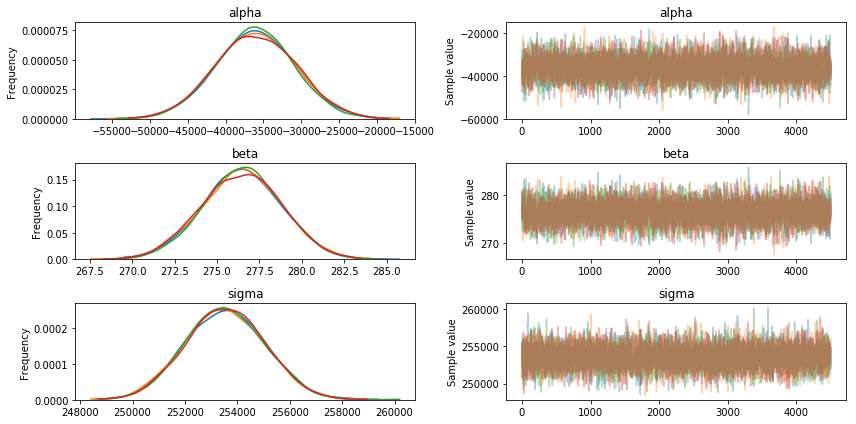

In [161]:
pm.traceplot(trace[500:]);

In [162]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-36116.751200,5238.527460,59.802911,-46542.306403,-25903.395234,6549.015996,1.000061
beta__0,276.469431,2.314016,0.026635,271.914416,280.912728,6580.749631,1.000088
sigma,253542.753032,1494.607047,16.629024,250619.933100,256387.866397,7328.057620,0.999984


**Compared to our sklearn implementation:**  
Intercept: -35970.9576422  
Slope: 276.408481445  

Let's see if this model is a good fit by plotting the posterior to an estimate of the distribution from the actual data

In [ ]:
ppc = pm.sample_ppc(trace, model=lr, samples=500);

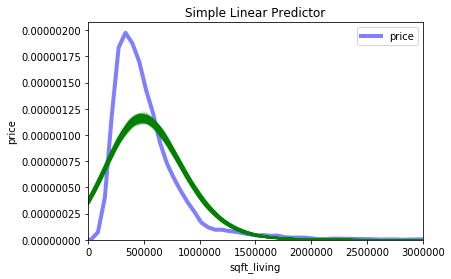

In [198]:
plt.title('Simple Linear Predictor')
plt.xlim(xmin=-1e2,xmax=3e6)
plt.ylabel('price')
plt.xlabel('sqft_living')
sns.kdeplot(y_train, alpha=0.5, lw=4, color='b')
for i in range(500):
    sns.kdeplot(ppc['y'][i], alpha=0.1, color='g')

Let's score the model

In [72]:
# Replace shared variables with testing set
model_input.set_value(np.array(X_test))
model_output.set_value(np.array(y_test))

The posterior predictive check will allow us to predict and score our model

In [73]:
pred_sample = pm.sample_ppc(trace[500:], model=lr, samples=1000,random_seed=42)

100%|██████████| 1000/1000 [00:00<00:00, 1214.17it/s]


In [74]:
pred = pred_sample['y'].mean(axis=0)

In [75]:
r2_score(y_test, pred)

0.4875150372234125

**Compared to our sklearn implementation:**  
R2: 0.487647626063

Make a single prediction for a single house with sqft_living = 3000

By feeding in a single point we can make a point prediction

In [90]:
model_input.set_value(np.array([3000]))

the out_put needs a value, but it can be set randomly

In [91]:
model_output.set_value(np.array([0]))

In [92]:
pred_sample = pm.sample_ppc(trace[500:], model=lr, samples=1000,random_seed = 42)

100%|██████████| 1000/1000 [00:00<00:00, 2841.82it/s]


In [93]:
pred_sample['y'].mean(axis=0)

806426.88353028742

### Part 2 Varying Intercept

Varying intercept

In [50]:
df_zip = pd.get_dummies(df.query('zipcode in @top_zips')[['price','zipcode','sqft_living']], columns=['zipcode'], drop_first=True)

df_zip['price_log'] = df_zip['price'].apply(lambda x: np.log(x))
df_zip['sqft_log'] = df_zip['sqft_living'].apply(lambda x: np.log(x))

X_cols = df_zip.columns[1:]
X_cols = X_cols.drop(['sqft_living','price_log'])

X_train, X_test, y_train, y_test = train_test_split(df_zip[X_cols], df_zip[['price_log']], test_size=0.33, random_state=42)

model_input = theano.shared(np.array(X_train))

model_output = theano.shared(np.array(y_train))

In [247]:
df_zip.sort_values('zipcode_98002',ascending=False).reset_index(drop=True).head()

,price,sqft_living,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,...,sqft_living_zipcode_98148,sqft_living_zipcode_98155,sqft_living_zipcode_98166,sqft_living_zipcode_98168,sqft_living_zipcode_98177,sqft_living_zipcode_98178,sqft_living_zipcode_98188,sqft_living_zipcode_98198,sqft_living_zipcode_98199,pred
0,201000,900,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,182996.645236
1,300000,1984,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,263317.296135
2,142500,690,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,167436.371538
3,125000,920,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,184478.576065
4,213500,1220,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,206707.538490


In [53]:
lr = pm.Model()

with lr:
    
    alpha = pm.Normal('alpha', mu=0, sd=10e4, shape=(1))
    betas = pm.Normal('betas', mu=0, sd=10e4, shape=(1,len(X_cols)))
    sigma = pm.HalfNormal('sigma', sd=10e4)
    
    temp = alpha + theano.dot(model_input, betas.T)
    
    y = pm.Lognormal('y', mu=temp , sd=sigma, observed=model_output)

In [54]:
with lr:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, betas, alpha]
100%|██████████| 5500/5500 [03:28<00:00, 26.41it/s]
The acceptance probability does not match the target. It is 0.957053099982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.95934132064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.947639698859, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.962834443565, but should be close to 0.8. Try to increase the number of tuning steps.


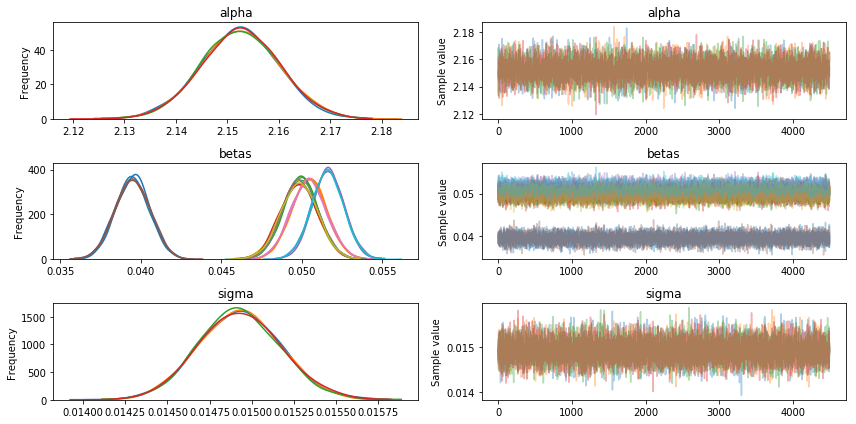

In [55]:
pm.traceplot(trace[500:]);

In [56]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.152347,0.007494,0.000092,2.137739,2.167243,8341.127001,0.999962
betas__0_0,0.039475,0.001063,0.000011,0.037370,0.041510,10767.679845,1.000324
betas__0_1,0.050425,0.001081,0.000010,0.048291,0.052559,9360.514915,0.999949
betas__0_2,0.049899,0.001068,0.000011,0.047836,0.052018,10029.444334,1.000026
betas__0_3,0.049801,0.001134,0.000011,0.047525,0.051980,10145.240117,0.999974
betas__0_4,0.051601,0.000978,0.000012,0.049688,0.053535,8627.645395,0.999979
sigma,0.014928,0.000240,0.000002,0.014459,0.015403,15159.187164,0.999909


In [57]:
model_input.set_value(np.array(X_test))
model_output.set_value(np.array(y_test))

pred_sample = pm.sample_ppc(trace[500:], model=lr, samples=1000,random_seed=42)

pred = pred_sample['y'].mean(axis=0)

r2_score(y_test, pred)

100%|██████████| 1000/1000 [00:00<00:00, 2537.56it/s]


0.70862690417463692

# Appendix B - Resources

PyMC3's Documentation:
https://docs.pymc.io/getting_started.html

Thomas Wiecki's Blog:
http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/

Chad Scherrer - Metis Seattle Senior DS's Blog:
https://cscherrer.github.io/post/bayesian-changepoint/

Videos:  

Nicole Carlson - Turning PyMC3 into scikit learn: 
https://www.youtube.com/watch?v=zGRnirbHWJ8

Nicole Carlson | A Quickstart Guide to PyMC3: 
https://www.youtube.com/watch?v=rZvro4-nFIk

Thomas Wiecki - Probablistic Programming Data Science with PyMC3: 
https://www.youtube.com/watch?v=LlzVlqVzeD8

John Salvatier: Bayesian inference with PyMC 3: 
https://www.youtube.com/watch?v=VVbJ4jEoOfU

Christopher Fonnesbeck - Introduction to Statistical Modeling with Python - PyCon 2017: 
https://www.youtube.com/watch?v=TMmSESkhRtI